#Object detection and segmentation
In this Lab you will learn about

- Fully convolutional networks
- Localization
- Object detection with a YOLO-like network
- Image segmentation with U-Net

We will not have time to reproduce exactly the network architectures covered in Lecture 8. Instead this Lab serves is to give your some intuition about fundamental properties of these networks.

**Before we start - remember to set runtime to GPU**

**NOTE:** In case you have trouble running Keras/TensorFlow in Colab, try one of the following:

In [1]:
# Try this
#!pip install --upgrade tensorflow==1.8.0

# ... or this
#%tensorflow_version 1.x

# Check TensorFlow version
#import tensorflow as tf
#print(tf.__version__)

##1. Download the MNIST dataset
As usual:

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Print some stats:

In [ ]:
# Input shape: 28 x 28 x 1 = image with one color channel
print('input_shape :',input_shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

##2. Train a simple CNN classifier
Set up CNN:

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model

inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Train the model for four epochs:

In [ ]:
batch_size = 32
epochs = 4

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

##3. Task 1: Simple sliding window
Sliding window  (i.e., repeating the same operation on an image at many different locations) is a core operation in many computer vision tasks.

![alt text](https://miro.medium.com/max/576/1*Mj8WKVKf_RpiAsX3SC1ZdQ.png)

To perform sliding window efficiently - and to handle input images of varying shape - most modern CNNs are *fully convolutional*. The term is not uniquely defined, but at its core it addresses the issue that fully connected layers (or dense layers) require that the input vector has a fixed, predetermined shape. There are basically two solutions to this problem:

1. Perform some sort of pooling operation on the last feature map of the convolutional encoder, such that the input to the fully connected layers has a fixed shape, regardless of the shape of the input image. For instance, *global average pooling* takes an NxNxC volume and reduces it to a C-dimensional vector by averaging the NxN valus of each channel. (see [Task 2.4 of Lab 7](https://github.com/aivclab/dlcourse/blob/master/Lab7_Solution.ipynb)).
2. Convert the fully connected layers into convolutional layers. This allows the network to handle images of arbitrary shape. If the shape of the last feature map is NxNxC, the first step of replacing the fully connected layers with convolutional layers is to perform convolution with K different NxN sized filters to produce an output volume of shape 1x1xK. Performing successive 1x1 convolutions on this volume "mimics" the traditional fully connected layers. 

The main difference between the two approaches above is that in *1.* the output shape is always the same, whereas in *2.* the output shape increases as the shape of the input image increases. This is because *2.* performs a kind of *sliding window* operation. We will implement this later.

###Create a larger test image to perform sliding window on
To motivate why we need fully convolutional networks to perform sliding window effeciently, lets first consider simple sliding window, where each window is run through a CNN.

The CNN that we trained above takes input images of size 28 x 28 and produces a 10-dimensional output vector of class probabilities. Now, suppose that the input image is three times as large (i.e., it has size 84 x 84), but the digits have the same absolute scale/shape as before. Let's generate and display such a test image using zero padding:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Change to select another test image
i = 0

# Dimensions are [batch_size, height, width, channels]
img = np.reshape(x_train[i,:],(1,28,28,1))

# Pad with zeros to obtain image of size (28 + 2*padsize) = 84 if padsize = 28
padsize = 28
img_large = np.pad(img,((0,0),(padsize,padsize),(padsize,padsize),(0,0)))
print('Original shape',img.shape)
print('Larger image shape',img_large.shape)

# Display
plt.subplot(1,2,1); plt.imshow(img.squeeze(),cmap='gray'); plt.title('Original (28 x 28)');
plt.subplot(1,2,2); plt.imshow(img_large.squeeze(),cmap='gray'); plt.title('Larger image (84 x 84)');

###Run sliding window
We should be able to detect the digit in the larger image (`img_large`) by running our current CNN model over the image in a sliding window fashion. 
The input image is 84 x 84 pixels, and the network accepts images of shape 28x28. With a stride of 1, how many times can we run the network over the input image along each spatial dimension? Call this number `N`, insert it in the code block below, and run it. 

Please ask me (Henrik) if the task is unclear, or if you get stuck.

**Note** that it will take a while to run the code block below - that's the whole point :-)

In [ ]:
import time

# Initialize result array
N = ???
result = np.zeros((N,N,num_classes))

# Perform sliding window
start = time.time()
for x in range(N):
  for y in range(N):
    cropout = img_large[:,x:x+28,y:y+28,:]
    cropout = np.reshape(cropout,(1,28,28,1))
    result[x,y,:] = model.predict(cropout)

elapsed = time.time() - start
print('Elapsed time',elapsed)

# Show result
plt.figure(figsize=(20,6))
for c in range(num_classes):
  plt.subplot(1,num_classes,c+1)
  plt.imshow(result[:,:,c],vmin=0.,vmax=1.,cmap='gray')
  plt.title(str(c))

### Questions
1. What are we looking at here? That is, explain what the output images (`result`) show.
2. How long time did it take to run sliding window this way?

##4. Task 2: Efficient sliding window with FCN
Sliding window as implemented above takes several seconds, even for this tiny image. To make the sliding window operation more efficient, we can convert our model to a fully convolutional network (FCN) by converting the fully connected layers to convolutional layers.

In summary, the procedure involves the following steps:

1. First set up an FCN equivalent to the CNN that we used above.
2. Train the FCN on the 28 x 28 training images (`x_train`).
3. Modify the FCN architecture such that it takes input images of arbitrary input shape (and test it on the 84 x 84 image).

The latter is a two-step procedure, where we first modify the FCN architecture a little bit (by removing a flatten layer), then copy the weights from the trained network.


###Step 1 - set up FCN
As a first step, convert our fully connected model into an FCN by replacing the fully connected layers with convolution layers. You can do this by filling in the missing code below (see comments to get help):


In [ ]:
from keras.activations import softmax

def depthwiseSoftmax(x):
    return softmax(x,axis=3)

def FCN(inputs,train_mode=False):
  # Encoder (convolutional base)
  x = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)

  # 1. At this point x has shape (None, 7, 7, 32)  
  x = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)

  # 2. At this point x has shape (None, 1, 1, 64)
  predictions = Conv2D(filters=???, kernel_size=???, padding=???, activation=depthwiseSoftmax, padding='same')(x)

  # 3. At this point predictions has shape (None, 1, 1, num_classes)

  # The flatten operation is required during training only
  if train_mode:
    predictions = Flatten()(predictions)
    # 4. At this point "predictions" has shape (None, num_classes)

  fcn = Model(inputs=inputs, outputs=predictions)

  return fcn

fcn = FCN(inputs=inputs,train_mode=True)
fcn.summary()

###Step 2 - train FCN
Unfortunately, it is not so straight forward to transfer the learned weights from the existing CNN (`model`) to the FCN (`fcn`). So we need to quickly train it:

In [ ]:
epochs = 4

fcn.compile(loss='categorical_crossentropy',
            optimizer='SGD',
            metrics=['accuracy'])

history = fcn.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

####Question
1. Why is the `predictions = Flatten()(x)` operation requires during training, but not during test?

###Step 3.1 - make FCN accept images of arbitrary shape
Now, that we have trained our FCN, we can modify it to take input images of arbitrary shape. This is a two-step procedure. First set input height/width to `None` and remove the `Flatten` operation by setting `train_mode=False`:

In [ ]:
# Tell Keras that height/width can be arbitrary
large_input_shape = ((None,None,1))
large_inputs = Input(large_input_shape)

fcn_large = FCN(inputs=large_inputs,train_mode=False)
fcn_large.summary()

Next, copy the weights from the trained model:

In [ ]:
# copy weights from one model to another model    
# tested in Keras 1.x    
def copyModel2Model(model_source,model_target):        
    for l_tg,l_sr in zip(model_target.layers,model_source.layers):
        wk0 = l_sr.get_weights()
        l_tg.set_weights(wk0)
    print("model source was copied into model target")

copyModel2Model(fcn,fcn_large)

model source was copied into model target


Let's verify that we get the same results with `fcn` and `fcn_large`:

In [ ]:
# FCN that always expects 28 x 28 input
result = fcn.predict(img)
print('result',result)
print('result.shape',result.shape)

# FCN that accepts arbitrary input shape (but fed with 28x28 image here)
result_large = fcn_large.predict(img)
print(result_large)
print('result_large.shape',result_large.shape)

####Questions:
1. Is there any sliding window going on here (when running `fcn_large`)?
2. Why are the output shapes `result.shape` and `result_large.shape` different?

###Test speed (FCN vs simple slinding window)

Finally, let's verify that `fcn_large` performs sliding window much faster than the simple sliding window above by processing the 84 x 84 image, `img_large`:

In [ ]:
start = time.time()
result_large = fcn_large.predict(img_large)
elapsed = time.time() - start
print(result_large.shape)
print(elapsed)

Display the results:

In [ ]:
# Show input image
plt.figure()
plt.imshow(img_large.squeeze(),cmap='gray')

# Show result
plt.figure(figsize=(20,6))
for c in range(num_classes):
  plt.subplot(1,num_classes,c+1)
  plt.imshow(result_large[:,:,:,c].squeeze(),vmin=0.,vmax=1.,cmap='gray')
  plt.title(str(c))

###Questions:
1. With simple sliding window, the output shape of `results` was NxNx10 = 56x56x10. However, when using FCN for sliding window, the output shape is 15x15x10. Why?

##5. Task 3: Simple localization
The goal of localization is to find the bounding box of a single object in an image. This is a regression problem, where we seek to predict the corners of the bounding box (or eqivalently one corner + height and width of the bbox). Either way, the output of the regression is 4 numbers.

Localization can be performed in the *class agnostic* way, where we use the same regressor for all classes, or the *class specific* way. In the latter case, the output of the regression is C x 4 dimensional, where C is the number of classes.

Here we will focus on the simpler class agnostic approach.

###Train and test data
First, let's create train and test data for this task.

In [ ]:
num_train = x_train.shape[0]
y_train_loc = np.zeros((num_train,4)) # Bounding box corners
for i in range(num_train):
  
  # Bounding box corners coordinates
  tmp = x_train[i,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_loc[i,0] = np.min(rows) # Upper left corner - row coordinate
  y_train_loc[i,1] = np.min(cols) # Upper left corner - column coordinate
  y_train_loc[i,2] = np.max(rows) # Lower right corner - row coordinate
  y_train_loc[i,3] = np.max(cols) # Lower right corner - column coordinate

num_test = x_test.shape[0]
y_test_loc = np.zeros((num_test,4))
for i in range(num_test):
  
  # Bounding box corners coordinates
  tmp = x_test[i,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_test_loc[i,0] = np.min(rows)
  y_test_loc[i,1] = np.min(cols)
  y_test_loc[i,2] = np.max(rows)
  y_test_loc[i,3] = np.max(cols)

Show some examples:

In [ ]:
import cv2
plt.figure(figsize=(20,4))
for i in range(10):
  img = np.tile(x_train[i,:,:,:],(1,1,3))
  xmin = int(y_train_loc[i,0]) # row
  ymin = int(y_train_loc[i,1]) # col
  xmax = int(y_train_loc[i,2]) # row
  ymax = int(y_train_loc[i,3]) # col
  cv2.rectangle(img,(ymin,xmin),(ymax,xmax),(0,1,0),1)

  ax = plt.subplot(2,5,i+1)
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Implement Localization network
Your task is to implement and train a CNN that predicts the bounding box coordinates: `(ymin,xmin),(ymax,xmax)`. You can use the CNN architecture that we used and modify the last layer only. It should output 4 real-valued numbers.

**Note:** the last layer has no activation function. Why? Because this is a regression problem, where the output values are not necessarily limited to stay within a pre-deterrmined range.

In [ ]:
inputs = Input(shape=(28, 28, 1))

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
predictions = Dense(???)(x)

# This creates a callable model that includes the Input layer and the prediction layer
localizer = Model(inputs=inputs, outputs=predictions)

localizer.summary()

###Training
Recall that localization is a regression problem and not a classification problem. For regression, we usually want to minimize the L2 loss or the *mean squared error* (mse) as it is called in Keras. The procedure for training the localizer is more or less the same as for the classifier, excpet that we need to change the loss to `mse`:

In [ ]:
batch_size = 32
epochs = 4

localizer.compile(loss='mse',
                  optimizer='Adam')

history = localizer.fit(x_train, y_train_loc,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_loc))

###Model evaluation
Display test results (do not expect perfect results...):

In [ ]:
# Predict bounding boxes for one test batch
result = localizer.predict(x_test[0:batch_size,:])

plt.figure(figsize=(20,4))
for i in range(10):

  img = np.tile(x_test[i,:,:,:],(1,1,3))
  xmin = int(result[i,0]) # row
  ymin = int(result[i,1]) # col
  xmax = int(result[i,2]) # row
  ymax = int(result[i,3]) # col
  cv2.rectangle(img,(ymin,xmin),(ymax,xmax),(0,1,0),1)

  ax = plt.subplot(2,5,i+1)
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

##6. Task 4: Object detection
Classification + Localization predicts one class label and one bounding box per image. This is problematic if the image contains multiple objects. Object detection is about detecting and classifying multiple objects in images. Object detection networks output the corner coordinates of the bounding box of each detect object, along with a class label.

![alt text](https://miro.medium.com/max/576/1*Mj8WKVKf_RpiAsX3SC1ZdQ.png)

There are many ways to implement object detection with CNNs. You may want to take a look at this 3-part tutorial:
- [A Step-by-Step Introduction to the Basic Object Detection Algorithms (Part 1)](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)
- [A Practical Implementation of the Faster R-CNN Algorithm for Object Detection (Part 2 – with Python codes)](https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/)
- [A Practical Guide to Object Detection using the Popular YOLO Framework – Part III (with Python codes)](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/?utm_source=blog&utm_medium=implementation-faster-r-cnn-python-object-detection)

The R-CNN family of techniques we saw in Lecture 8 primarily use regions to localize the objects within the image. In short
- **R-CNN** feeds each region proposal through a CNN to predict the class and bounding box, which is really slow
- **Fast R-CNN** speeds up R-CNN by running the image through a fully convolutional CNN once, then extracts regions from the resulting feature volume to predict classes and bounding boxes.
- **Faster R-CNN** speeds up Fast R-CNN by integrating the region proposal step into the network (instead of running selective search).

The R-CNN family of techniques does not look at the entire image, only at the parts of the images which have a higher chance of containing an object. The **YOLO** framework (You Only Look Once) on the other hand, deals with object detection in a different way. It takes the entire image in a single instance and predicts the bounding box coordinates and class probabilities for these boxes. The biggest advantage of using YOLO is its superb speed – it’s incredibly fast and can process 45 frames per second. YOLO also understands generalized object representation.

![alt text](https://miro.medium.com/max/1152/1*m8p5lhWdFDdapEFa2zUtIA.jpeg)

The basic idea of our simple YOLO-like object detector below is as follows:

- The input image is divided into a grid (7-by-7 in the paper).
- Each grid cell can be the center of one object, or no object. The object can be bigger or smaller than the cell, it doesn't matter; the important thing to consider is whether a cell represents the center of an object or not.
- If a cell is the center of an object, we want our model to know during training (and predict it at test time). For this purpose, we introduce a concept called *confidence*: The confidence is 1 if the cell represents an objects, and otherwise it is 0. In the figure above, the confidence - as predicted by the model - is represented by the thickness of the black boxes in the top-most image.
- If the confidence is 1, it means there is an object, so we want to predict its bounding box (relative to the center of the grid cell).
- Also, we want to predict the class label of the object. To be more precise, we want our model to predict the class probabilities (for all classes).

**Example:**
If the input image has shape 64x64, the output of the YOLO-like model will have shape 2x2x15:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).

This totals 15 outputs per cell.


###Set up YOLO-like network
Your first task is to fill in the empty spots below (marked with ???), then run the code block to set up the object detection network.

In [ ]:
from keras.layers import concatenate
from keras.activations import softmax

def depthwiseSoftmax(x):
    return softmax(x,axis=3)

input_img = Input(shape=(64, 64, 1))

x = Conv2D(8, 33, activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Notice that all three outputs use the same encoder

# 1. This predicts whether there is an object in a cell or not
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
confidence = Conv2D(???, 1, activation='sigmoid', padding='same')(x)

# 2. This predicts the bounding box coordinates for each cell
x = Conv2D(4, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
box = Conv2D(???, 1, padding='same')(x)

# 3. This predicts the class probabilities for each cell
x = Conv2D(16, 3, activation='relu', padding='same')(encoded)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
classes = Conv2D(???, 1, activation=depthwiseSoftmax, padding='same')(x)

# Merge output
merged = concatenate([confidence, box, classes])

objdet = Model(input_img, merged)
objdet.compile(optimizer='Adam', loss='mse')

objdet.summary()

###Training data
Let's generate some training data for our object detector.

The training images (`x_train_obj`) will be 64x64, where two of the four quadrants will contain one handwritten digit. This just serves to illustrate that we can teach a network to detect and classify more than one digit per input image.

The output is (`y_train_obj`) is 2x2x15 as explained above:
- 1 output per cell for the confidence (is there an object or not?)
- 4 outputs per cell corresponding to the upper left and lower right coordinates of the bounding box
- 10 outputs per cell corresponding to the class probabalities (assuming we have 10 classes).


In [ ]:
x_train_obj = np.zeros((5000,64,64,1))
y_train_obj = np.zeros((5000,2,2,15))

for i in range(5000):
  
  ## 1 
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,0,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,0,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,0,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,0,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,0,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,0,q,4] = np.max(cols) + y_off_start

  ## 2
  q = np.random.randint(0,2) # 3rd or 4rd image quadrant?
  
  # Random image
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_obj[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]
  
  # Set confidence to 1
  y_train_obj[i,1,q,0] = 1

  # Class label
  label = np.argmax(y_train[rand_ix,:])
  y_train_obj[i,1,q,5+label] = 1

  # Bounding box corners coordinates
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  rows = ix[0]
  cols = ix[1]  
  y_train_obj[i,1,q,1] = np.min(rows) + x_off_start
  y_train_obj[i,1,q,2] = np.min(cols) + y_off_start
  y_train_obj[i,1,q,3] = np.max(rows) + x_off_start
  y_train_obj[i,1,q,4] = np.max(cols) + y_off_start

Display example outputs

In [ ]:
plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      object_present = np.round(y_train_obj[k,i,j,0])
      if object_present:
        class_index = np.argmax(y_train_obj[k,i,j,5:])
        xmin = int(y_train_obj[k,i,j,1] + i*32) # row
        ymin = int(y_train_obj[k,i,j,2] + j*32) # col
        xmax = int(y_train_obj[k,i,j,3] + i*32) # row
        ymax = int(y_train_obj[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

###Training
We are ready to start training the model.

In [ ]:
objdet.fit(x_train_obj, y_train_obj, epochs=50, batch_size=128,shuffle=True,verbose=1)

###Model evaluation
The code below shows displays the results for 10 example images. For each cell in each image, it predicts the confidence, the bounding box and the class label.

However, the confidence is not used for anything, so all boxes and class labels are shown, regardless of whethter the confidence is high or low.

**Your task** is to fix the code, such that bounding boxes and class labels are only shown if the model is confident that there is on object in a given cell. Fill in the `???` (there are multiple solutions).

In [ ]:
out = objdet.predict(x_train_obj[0:10,:,:,:])

plt.figure(figsize=(20,4))
for k in range(10):
  result = np.tile(x_train_obj[k,:,:,:],(1,1,3))

  for i in range(2):
    for j in range(2):
      confidence = out[k,i,j,0]
      object_present = ???
      if object_present:
        class_index = np.argmax(out[k,i,j,5:])
        xmin = int(out[k,i,j,1] + i*32) # row
        ymin = int(out[k,i,j,2] + j*32) # col
        xmax = int(out[k,i,j,3] + i*32) # row
        ymax = int(out[k,i,j,4] + j*32) # col
        cv2.rectangle(result,(ymin,xmin),(ymax,xmax),(0,255,0),1)
        cv2.putText(result, str(class_index), (ymin-10, xmin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0),lineType=cv2.LINE_AA)
  ax = plt.subplot(2,5,k+1)
  plt.imshow(result)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

**Note:** Do not expect perfect results. Our object detection network is over-simplified compared to state-of-the-art. Or more precisely, the loss function is far from ideal, so we are optimizing *the wrong objective*, so to say.

##7. Task 5: Image segmentation with U-Net

###Representing the task
Image segmentation is a form of image-to-image transformation. It outputs a softmax classification per pixel. So if the input image has size 64x64, and there are 10 classes, the output will have shape 64x64x10. That is, for each pixel the network outputs a vector of class probabilities:

![alt text](https://miro.medium.com/max/498/1*P1ooLjeSwhxeJGyFawCvaQ.png)

###Training data
We will create training images (x_train_seg) of size 64x64, where two of the four quadrants will contain one handwritten digit. This is to illustrate that we can teach a network to identify and segment more than one digit per input image.

The target output (`y_train_seg`) will be 64x64x10, with a one-hot vector for each pixel indicating the correct class.

In [ ]:
x_train_seg = np.zeros((5000,64,64,1))
y_train_seg = np.zeros((5000,64,64,10))

for i in range(5000):
  
  ## 1
  q = np.random.randint(0,2) # 1st or 2nd image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,0+x_off_start:28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()
  
  ## 2
  q = np.random.randint(0,2) #  3rd or 4th image quadrant?
  rand_ix = np.random.randint(0,x_train.shape[0])
  x_off_start = np.random.randint(0,5)
  y_off_start = np.random.randint(0,5)
  x_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,:] = x_train[rand_ix,:,:,:]

  # Mask
  tmp = x_train[rand_ix,:,:,:]
  ix = np.where(tmp>0.1)
  tmp = np.zeros(tmp.shape)
  tmp[ix] = 1
  label = np.argmax(y_train[rand_ix,:])
  y_train_seg[i,32+x_off_start:32+28+x_off_start,32*q+y_off_start:32*q+28+y_off_start,label] = tmp.squeeze()

Show examples:

In [ ]:
# Show examples of input to output mappings
for ex in range(5):
  plt.figure(figsize=(20,6))
  rand_ix = np.random.randint(0,5000)
  ax = plt.subplot(1,11,1)
  plt.imshow(x_train_seg[rand_ix,:,:,:].squeeze())
  plt.title('Input image')
  for i in range(10):
    ax = plt.subplot(1,11,i+2)
    plt.imshow(y_train_seg[rand_ix,:,:,i].squeeze())
    plt.title("Out class "+str(i))

**Your task** is to implement a function `show_segmentation` that takes a 64x64x10 volume of class probabilities as input (e.g., `y_train_seg`) and displays a 64x64 image, where the pixel intensity at a given location is the class index with the highest probability.

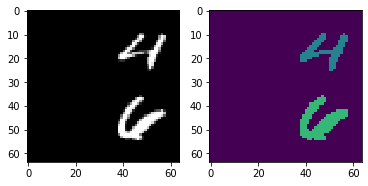

In [ ]:
def show_segmentation(x):
  plt.imshow(???,vmin=0,vmax=9)
  
plt.subplot(121);
plt.imshow(x_train_seg[0,:,:,:].squeeze(),cmap='gray')
plt.subplot(122)
show_segmentation(y_train_seg[0,:,:,:].squeeze())

###U-Net for image segmentation
See if you can implement a U-Net inspired by this one (not necessarily identical to), except that it should operate on 64x64 images instead of 128x128 images:

![alt text](https://miro.medium.com/max/937/1*yzbjioOqZDYbO6yHMVpXVQ.jpeg)

Recall that
- 2@Conv layers means that two consecutive Convolution Layers are applied
- c1, c2, ... c9 are the output tensors of Convolutional Layers
- p1, p2, p3 and p4 are the output tensors of Max Pooling Layers
- u6, u7, u8 and u9 are the output tensors of up-sampling (transposed convolutional is called `Conv2DTranspose` in Keras) layers.

**IMPORTANT NOTE** In the figure above, the indices of the encoder go from 1 to 5 (e.g., c1, c2, ..., c5), and the indices of the decoder go from 6 to 9 (e.g., u6, u7, ..., u9). Because we are working on images with half the with and height, our indices go from **1 to 4 in the encoder** and **5 to 8 in the decoder**.




In [ ]:
from keras.layers import concatenate, Conv2DTranspose

def depthwiseSoftmax(x):
    return softmax(x,axis=3)

inputs = Input(shape=(64, 64, 1))

# Encoder
c1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
c1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c1)
p1 = MaxPooling2D(pool_size=(2, 2))(c1)
c2 = ???
p2 = ???
c3 = ???
p3 = ???
c4 = ???

# Decoder
u5 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c4)
u5 = concatenate([c3,u5], axis = 3)
c5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u5)
c5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c5)
u6 = ???
c6 = ???
u7 = ???
c7 = ???

# Perform softmax on each pixel, so axis should be 3 because output has shape: batch_size x 64 x 64 x num_classes
c8 = Conv2D(num_classes, 1, activation = depthwiseSoftmax)(c7)

model = Model(inputs, c8)
model.summary()
model.compile(optimizer='Adam', loss = 'binary_crossentropy')

###Training

In [ ]:
model.fit(x_train_seg, y_train_seg, epochs=30, batch_size=64,shuffle=True,verbose=1)

###Model evaluation

In [ ]:
# Pick 4 random examples
rand_ix = np.random.randint(0,5000,4)
out = model.predict(x_train_seg[rand_ix,:,:,:])
ref = y_train_seg[rand_ix,:,:,:].squeeze()
for k in range(4):
  plt.figure(figsize=(20,4))
  plt.subplot(1,3,1)
  plt.imshow(x_train_seg[rand_ix[k],:,:,:].squeeze(),cmap='gray')
  plt.title('Input image')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  plt.subplot(1,3,2)
  show_segmentation(ref[k,:,:,:].squeeze())
  plt.title('Ground truth')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  plt.subplot(1,3,3)
  show_segmentation(out[k,:,:,:].squeeze())
  plt.title('Predicted')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)